# Stock Analysis Using LSTM - MVP
This notebook adapted from https://www.kaggle.com/faressayah/stock-market-analysis-prediction-using-lstm

# Import required libraries and set up notebook


In [6]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

# For reading stock data from yahoo
from pandas_datareader.data import DataReader

# For time stamps
from datetime import datetime

# for LSTM
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler

In [54]:
# switches
plot_all = False

In [7]:
# DataReader: https://riptutorial.com/pandas/topic/1912/pandas-datareader
# https://pandas-datareader.readthedocs.io/en/latest/remote_data.html
# 
# Set up End and Start times for data grab
end = datetime.now()
start = datetime(end.year - 1, end.month, end.day)
tester = DataReader('AAPL', 'yahoo', start, end)
tester.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-01-24,80.832497,79.379997,80.062500,79.577499,146537600.0,78.896149
2020-01-27,77.942497,76.220001,77.514999,77.237503,161940000.0,76.576187
2020-01-28,79.599998,78.047501,78.150002,79.422501,162234000.0,78.742477
2020-01-29,81.962502,80.345001,81.112503,81.084999,216229200.0,80.390747
2020-01-30,81.022499,79.687500,80.135002,80.967499,126743200.0,80.274246


In [11]:
# The tech stocks used for this analysis
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']
# dictionary to seed stock handles with company names
company_dict = {'AAPL':"APPLE", 'GOOG':"GOOGLE", 'MSFT':"MICROSOFT", 'AMZN':"AMAZON"}

# Set up End and Start times for data grab
end = datetime.now()
start = datetime(end.year - 1, end.month, end.day)

stock_dict = {}
#For loop for grabing yahoo finance data and setting as a dataframe
# TODO correct use of globals() here
seeded = False
for stock in tech_list:   
    # Set DataFrame as the Stock Ticker
    stock_dict[stock] = DataReader(stock, 'yahoo', start, end)
    # add column for company name
    stock_dict[stock]['company_name'] = company_dict[stock]
    # build up overall dataframe containing stock info for all companies
    if seeded:
        df = pd.concat([df,stock_dict[stock]],axis=0)
    else:
        seeded = True
        df = stock_dict[stock]
df.tail(10)

,High,Low,Open,Close,Volume,Adj Close,company_name
Date,,,,,,,
2021-01-08,3190.639893,3142.199951,3180.000000,3182.699951,3534300.0,3182.699951,AMAZON
2021-01-11,3156.379883,3110.000000,3148.010010,3114.209961,3683400.0,3114.209961,AMAZON
2021-01-12,3142.139893,3086.000000,3120.000000,3120.830078,3514600.0,3120.830078,AMAZON
2021-01-13,3189.949951,3122.080078,3128.439941,3165.889893,3321200.0,3165.889893,AMAZON
2021-01-14,3178.000000,3120.590088,3167.520020,3127.469971,3070900.0,3127.469971,AMAZON
2021-01-15,3142.550049,3095.169922,3123.020020,3104.250000,4214200.0,3104.250000,AMAZON
2021-01-19,3145.000000,3096.000000,3107.000000,3120.760010,3305100.0,3120.760010,AMAZON
2021-01-20,3279.800049,3175.000000,3181.989990,3263.379883,5309800.0,3263.379883,AMAZON
2021-01-21,3348.550049,3289.570068,3293.000000,3306.989990,4945100.0,3306.989990,AMAZON


Let's go ahead and play aorund with the AAPL DataFrame to get a feel for the data

# Create dataframe

In [12]:
# Summary Stats
stock_dict['AAPL'].describe()

,High,Low,Open,Close,Volume,Adj Close
count,252.000000,252.000000,252.000000,252.000000,2.520000e+02,252.000000
mean,99.766488,96.875774,98.292659,98.378680,1.566257e+08,98.113678
std,23.044460,22.562308,22.931885,22.793580,7.051495e+07,22.936554
min,57.125000,53.152500,57.020000,56.092499,4.669130e+07,55.744217
25%,79.665623,77.701876,78.704374,78.626249,1.072792e+08,78.349566
50%,97.689999,95.872498,96.840000,96.761250,1.375974e+08,96.420753
75%,119.304998,116.152498,118.042498,117.640001,1.875871e+08,117.512497
max,139.850006,135.020004,138.050003,139.070007,4.268848e+08,139.070007


In [13]:
# General info
stock_dict['AAPL'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 252 entries, 2020-01-24 to 2021-01-22
Data columns (total 7 columns):
High            252 non-null float64
Low             252 non-null float64
Open            252 non-null float64
Close           252 non-null float64
Volume          252 non-null float64
Adj Close       252 non-null float64
company_name    252 non-null object
dtypes: float64(6), object(1)
memory usage: 15.8+ KB


In [55]:
# Let's see a historical view of the closing price

if plot_all:
    plt.figure(figsize=(12, 8))
    plt.subplots_adjust(top=1.25, bottom=1.2)

    for i, company in enumerate(tech_list, 1):
        plt.subplot(2, 2, i)
        stock_dict[company]['Adj Close'].plot()
        plt.ylabel('Adj Close')
        plt.xlabel(None)
        plt.title(f"{tech_list[i - 1]}")

In [68]:
# Now let's plot the total volume of stock being traded each day
if plot_all:
    plt.figure(figsize=(12, 8))
    plt.subplots_adjust(top=1.25, bottom=1.2)

    for i, company in enumerate(tech_list, 1):
        plt.subplot(2, 2, i)
        stock_dict[company]['Volume'].plot()
        plt.ylabel('Volume')
        plt.xlabel(None)
        plt.title(f"{tech_list[i - 1]}")

Now that we've seen the visualizations for the closing price and the volume traded each day, let's go ahead and caculate the moving average for the stock.

# 2. What was the moving average of the various stocks?

In [16]:
ma_day = [10, 20, 50]

for ma in ma_day:
    for company in tech_list:
        column_name = f"MA for {ma} days"
        stock_dict[company][column_name] = stock_dict[company]['Adj Close'].rolling(ma).mean()

In [17]:
print(stock_dict['GOOG'].columns)

Index(['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'company_name',
       'MA for 10 days', 'MA for 20 days', 'MA for 50 days'],
      dtype='object')


Now let's go ahead and plot all the additional Moving Averages

In [56]:
if plot_all:
    df.groupby("company_name").hist(figsize=(12, 12));

In [57]:
if plot_all:
    fig, axes = plt.subplots(nrows=2, ncols=2)
    fig.set_figheight(8)
    fig.set_figwidth(15)

    AAPL[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[0,0])
    axes[0,0].set_title('APPLE')

    GOOG[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[0,1])
    axes[0,1].set_title('GOOGLE')

    MSFT[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[1,0])
    axes[1,0].set_title('MICROSOFT')

    AMZN[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[1,1])
    axes[1,1].set_title('AMAZON')

    fig.tight_layout()

# 3. What was the daily return of the stock on average?

Now that we've done some baseline analysis, let's go ahead and dive a little deeper. We're now going to analyze the risk of the stock. In order to do so we'll need to take a closer look at the daily changes of the stock, and not just its absolute value. Let's go ahead and use pandas to retrieve teh daily returns for the Apple stock.

In [58]:
if plot_all:
    # We'll use pct_change to find the percent change for each day
    for company in tech_list:
        stock_dict[company]['Daily Return'] = stock_dict[company]['Adj Close'].pct_change()

    # Then we'll plot the daily return percentage
    fig, axes = plt.subplots(nrows=2, ncols=2)
    fig.set_figheight(8)
    fig.set_figwidth(15)

    stock_dict['AAPL']['Daily Return'].plot(ax=axes[0,0], legend=True, linestyle='--', marker='o')
    axes[0,0].set_title('APPLE')

    stock_dict['GOOG']['Daily Return'].plot(ax=axes[0,1], legend=True, linestyle='--', marker='o')
    axes[0,1].set_title('GOOGLE')

    stock_dict['MSFT']['Daily Return'].plot(ax=axes[1,0], legend=True, linestyle='--', marker='o')
    axes[1,0].set_title('MICROSOFT')

    stock_dict['AMZN']['Daily Return'].plot(ax=axes[1,1], legend=True, linestyle='--', marker='o')
    axes[1,1].set_title('AMAZON')

    fig.tight_layout()

Great, now let's get an overall look at the average daily return using a histogram. We'll use seaborn to create both a histogram and kde plot on the same figure.

In [59]:
# Note the use of dropna() here, otherwise the NaN values can't be read by seaborn
if plot_all:
    plt.figure(figsize=(12, 12))

    for i, company in enumerate(tech_list, 1):
        plt.subplot(2, 2, i)
        sns.distplot(stock_dict[company]['Daily Return'].dropna(), bins=100, color='purple')
        plt.ylabel('Daily Return')
        plt.title(company_dict[company])
    # Could have also done:
    #AAPL['Daily Return'].hist()

# 4. What was the correlation between different stocks closing prices?

Now what if we wanted to analyze the returns of all the stocks in our list? Let's go ahead and build a DataFrame with all the ['Close'] columns for each of the stocks dataframes.

In [25]:
# Grab all the closing prices for the tech stock list into one DataFrame
closing_df = DataReader(tech_list, 'yahoo', start, end)['Adj Close']

# Let's take a quick look
closing_df.head() 

Symbols,AAPL,GOOG,MSFT,AMZN
Date,,,,
2020-01-24,78.896149,1466.709961,163.309952,1861.640015
2020-01-27,76.576187,1433.900024,160.578888,1828.339966
2020-01-28,78.742477,1452.560059,163.725555,1853.250000
2020-01-29,80.390747,1458.630005,166.278503,1858.000000
2020-01-30,80.274246,1455.839966,170.968826,1870.680054


Now that we have all the closing prices, let's go ahead and get the daily return for all the stocks, like we did for the Apple stock.

In [26]:
# Make a new tech returns DataFrame
# pct_change() https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pct_change.html
# Percentage change between the current and a prior element.
# Computes the percentage change from the immediately previous row by default. This is useful in comparing the percentage of change in a time series of elements.
tech_rets = closing_df.pct_change()
# note that first row is NaN because there is no predecessor for the first row
tech_rets.head()

Symbols,AAPL,GOOG,MSFT,AMZN
Date,,,,
2020-01-24,NaN,NaN,NaN,NaN
2020-01-27,-0.029405,-0.022370,-0.016723,-0.017887
2020-01-28,0.028289,0.013013,0.019596,0.013624
2020-01-29,0.020932,0.004179,0.015593,0.002563
2020-01-30,-0.001449,-0.001913,0.028208,0.006825


Now we can compare the daily percentage return of two stocks to check how correlated. First let's see a sotck compared to itself.

In [60]:
# Comparing Google to itself should show a perfectly linear relationship
if plot_all:
    sns.jointplot('GOOG', 'GOOG', tech_rets, kind='scatter', color='seagreen')

In [61]:
# We'll use joinplot to compare the daily returns of Google and Microsoft
if plot_all:
    sns.jointplot('GOOG', 'MSFT', tech_rets, kind='scatter')

So now we can see that if two stocks are perfectly (and positivley) correlated with each other a linear relationship bewteen its daily return values should occur. 

Seaborn and pandas make it very easy to repeat this comparison analysis for every possible combination of stocks in our technology stock ticker list. We can use sns.pairplot() to automatically create this plot

In [62]:
# We can simply call pairplot on our DataFrame for an automatic visual analysis 
# of all the comparisons
if plot_all:
    sns.pairplot(tech_rets, kind='reg')

Above we can see all the relationships on daily returns between all the stocks. A quick glance shows an interesting correlation between Google and Amazon daily returns. It might be interesting to investigate that individual comaprison. While the simplicity of just calling sns.pairplot() is fantastic we can also use sns.PairGrid() for full control of the figure, including what kind of plots go in the diagonal, the upper triangle, and the lower triangle. Below is an example of utilizing the full power of seaborn to achieve this result.

In [63]:
# Set up our figure by naming it returns_fig, call PairPLot on the DataFrame
if plot_all:
    return_fig = sns.PairGrid(tech_rets.dropna())

    # Using map_upper we can specify what the upper triangle will look like.
    return_fig.map_upper(plt.scatter, color='purple')

    # We can also define the lower triangle in the figure, inclufing the plot type (kde) 
    # or the color map (BluePurple)
    return_fig.map_lower(sns.kdeplot, cmap='cool_d')

    # Finally we'll define the diagonal as a series of histogram plots of the daily return
    return_fig.map_diag(plt.hist, bins=30)

In [64]:
# Set up our figure by naming it returns_fig, call PairPLot on the DataFrame
if plot_all:
    returns_fig = sns.PairGrid(closing_df)

    # Using map_upper we can specify what the upper triangle will look like.
    returns_fig.map_upper(plt.scatter,color='purple')

    # We can also define the lower triangle in the figure, inclufing the plot type (kde) or the color map (BluePurple)
    returns_fig.map_lower(sns.kdeplot,cmap='cool_d')

    # Finally we'll define the diagonal as a series of histogram plots of the daily return
    returns_fig.map_diag(plt.hist,bins=30)

Finally, we could also do a correlation plot, to get actual numerical values for the correlation between the stocks' daily return values. By comparing the closing prices, we see an interesting relationship between Microsoft and Apple.

In [65]:
# Let's go ahead and use sebron for a quick correlation plot for the daily returns
if plot_all:
    sns.heatmap(tech_rets.corr(), annot=True, cmap='summer')

In [66]:
if plot_all:
    sns.heatmap(closing_df.corr(), annot=True, cmap='summer')

Fantastic! Just like we suspected in our PairPlot we see here numerically and visually that Microsoft and Amazon had the strongest correlation of daily stock return. It's also interesting to see that all the technology comapnies are positively correlated.

# 5. How much value do we put at risk by investing in a particular stock?

There are many ways we can quantify risk, one of the most basic ways using the information we've gathered on daily percentage returns is by comparing the expected return with the standard deviation of the daily returns.

In [67]:
# Let's start by defining a new DataFrame as a cleaned version of the orignal tech_rets DataFrame
rets = tech_rets.dropna()
if plot_all:
    area = np.pi*20

    plt.figure(figsize=(12, 10))
    plt.scatter(rets.mean(), rets.std(), s=area)
    plt.xlabel('Expected return')
    plt.ylabel('Risk')

    for label, x, y in zip(rets.columns, rets.mean(), rets.std()):
        plt.annotate(label, xy=(x, y), xytext=(50, 50), textcoords='offset points', ha='right', va='bottom', 
                     arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))

# 6. Predicting the closing price stock price of APPLE inc:

In [42]:
#Get the stock quote
# tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']
df_predict = {}
for company in tech_list:
    df_predict[company] = DataReader(company,data_source='yahoo', start='2012-01-01', end=datetime.now())
#df = DataReader('AAPL', data_source='yahoo', start='2012-01-01', end=datetime.now())
#Show teh data
df_predict['AAPL']

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,14.732143,14.607143,14.621429,14.686786,302220800.0,12.669562
2012-01-04,14.810000,14.617143,14.642857,14.765714,260022000.0,12.737653
2012-01-05,14.948214,14.738214,14.819643,14.929643,271269600.0,12.879066
2012-01-06,15.098214,14.972143,14.991786,15.085714,318292800.0,13.013701
2012-01-09,15.276786,15.048214,15.196429,15.061786,394024400.0,12.993060
...,...,...,...,...,...,...
2021-01-15,130.220001,127.000000,128.779999,127.139999,111235300.0,127.139999
2021-01-19,128.710007,126.940002,127.779999,127.830002,90757300.0,127.830002
2021-01-20,132.490005,128.550003,128.660004,132.029999,104319500.0,132.029999


In [69]:
if plot_all:
    plt.figure(figsize=(12, 12))
    #plt.title('Close Price History')
    for i, company in enumerate(tech_list,1):
        plt.subplot(2,2,i)
        plt.plot(df_predict[company]['Close'])
        plt.xlabel('Date', fontsize=18)
        plt.ylabel('Close Price USD ($)', fontsize=18)
        plt.title(company_dict[company])
        #plt.show()
    


In [47]:
def get_model_path():
    '''get the path for data files'''
    rawpath = os.getcwd()
    # data is in a directory called "data" that is a sibling to the directory containing the notebook
    path = os.path.abspath(os.path.join(rawpath, '..', 'models'))
    return(path)

In [52]:
def save_model(model,company):
    '''save the model to a file in directory models that is a peer of the directory containing this notebook'''
    model_path = get_model_path()
    modifier = datetime.now().strftime("%B%d%Y")
    save_model_path = os.path.join(model_path,company+modifier+'.h5')
    model.save(save_model_path)
    # no early stop, so make current model saved_model
    print("Saved model with name ",company+modifier+'.h5')
    


In [70]:
def one_col_df(df,col):
    data = df.filter([col])
    dataset = data.values
    training_data_len = int(np.ceil( len(dataset) * .8 ))
    return(data,dataset,training_data_len)

In [71]:
def scale_data(dataset):
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(dataset)
    return(scaled_data)

In [72]:
def create_x_y(scaled_data,training_data_len):
    '''convert scaled dataset into numpy x and y arrays for training'''
    #Create the training data set
    #Create the scaled training data set
    train_data = scaled_data[0:int(training_data_len), :]
    #Split the data into x_train and y_train data sets
    x_train = []
    y_train = []

    for i in range(60, len(train_data)):
        x_train.append(train_data[i-60:i, 0])
        y_train.append(train_data[i, 0])
        if i<= 61:
            print(x_train)
            print(y_train)
            print()

    # Convert the x_train and y_train to numpy arrays 
    x_train, y_train = np.array(x_train), np.array(y_train)

    #Reshape the data
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    # x_train.shape
    return(x_train,y_train)

In [37]:
'''
#Create a new dataframe with only the 'Close column
# filter: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.filter.html
data = df.filter(['Close'])
#Convert the dataframe to a numpy array
dataset = data.values
#Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .8 ))

training_data_len

1824

In [38]:
'''
#Scale the data


scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data
'''

array([[0.00590849],
       [0.0065393 ],
       [0.00784945],
       ...,
       [0.94373507],
       [0.98241713],
       [1.        ]])

In [39]:
'''
#Create the training data set
#Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
#Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

#Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# x_train.shape

[array([0.00590849, 0.0065393 , 0.00784945, 0.0090968 , 0.00890556,
       0.00933656, 0.00913961, 0.00880851, 0.00835752, 0.0097533 ,
       0.01101207, 0.01062387, 0.00849738, 0.01052682, 0.00852878,
       0.01602144, 0.01544201, 0.01619841, 0.01783395, 0.0188244 ,
       0.01874163, 0.01843622, 0.0197378 , 0.0209623 , 0.02234953,
       0.02459019, 0.029297  , 0.02936836, 0.03198865, 0.03394673,
       0.03058146, 0.03187733, 0.03185164, 0.03548523, 0.03496858,
       0.03592478, 0.0376431 , 0.03859932, 0.04135376, 0.04336035,
       0.04393979, 0.04414245, 0.04071153, 0.03988376, 0.04000651,
       0.04323192, 0.0441396 , 0.04608912, 0.05068461, 0.05681575,
       0.0556683 , 0.05567115, 0.06010395, 0.06149117, 0.06050355,
       0.05960159, 0.05866251, 0.0617823 , 0.06392307, 0.06481933])]
[0.06260435462809132]

[array([0.00590849, 0.0065393 , 0.00784945, 0.0090968 , 0.00890556,
       0.00933656, 0.00913961, 0.00880851, 0.00835752, 0.0097533 ,
       0.01101207, 0.01062387, 0.00

In [73]:
%%time

for company in tech_list:
    data,dataset,training_data_len = one_col_df(df_predict[company],'Close')
    scaled_data = scale_data(dataset)
    x_train, y_train = create_x_y(scaled_data,training_data_len)  

    #Build the LSTM model
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    #Train the model
    print("TRAINING STARTING FOR: ",str(company))
    model.fit(x_train, y_train, batch_size=1, epochs=1)
    # save the model
    save_model(model,company)

[array([0.00590849, 0.0065393 , 0.00784945, 0.0090968 , 0.00890556,
       0.00933656, 0.00913961, 0.00880851, 0.00835752, 0.0097533 ,
       0.01101207, 0.01062387, 0.00849738, 0.01052682, 0.00852878,
       0.01602144, 0.01544201, 0.01619841, 0.01783395, 0.0188244 ,
       0.01874163, 0.01843622, 0.0197378 , 0.0209623 , 0.02234953,
       0.02459019, 0.029297  , 0.02936836, 0.03198865, 0.03394673,
       0.03058146, 0.03187733, 0.03185164, 0.03548523, 0.03496858,
       0.03592478, 0.0376431 , 0.03859932, 0.04135376, 0.04336035,
       0.04393979, 0.04414245, 0.04071153, 0.03988376, 0.04000651,
       0.04323192, 0.0441396 , 0.04608912, 0.05068461, 0.05681575,
       0.0556683 , 0.05567115, 0.06010395, 0.06149117, 0.06050355,
       0.05960159, 0.05866251, 0.0617823 , 0.06392307, 0.06481933])]
[0.06260435462809132]

[array([0.00590849, 0.0065393 , 0.00784945, 0.0090968 , 0.00890556,
       0.00933656, 0.00913961, 0.00880851, 0.00835752, 0.0097533 ,
       0.01101207, 0.01062387, 0.00

TRAINING STARTING FOR:  AMZN
Epoch 1/1
1764/1764 [==============================] - 98s 56ms/step - loss: 4.7681e-04
Saved model with name  AMZNJanuary242021.h5
Wall time: 6min 50s


In [38]:
%%time
#Create the testing data set
#Create a new array containing scaled values from index 1543 to 2002 
test_data = scaled_data[training_data_len - 60: , :]
#Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

Wall time: 2.22 s


4.032431444824946

c:\users\ryanm\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


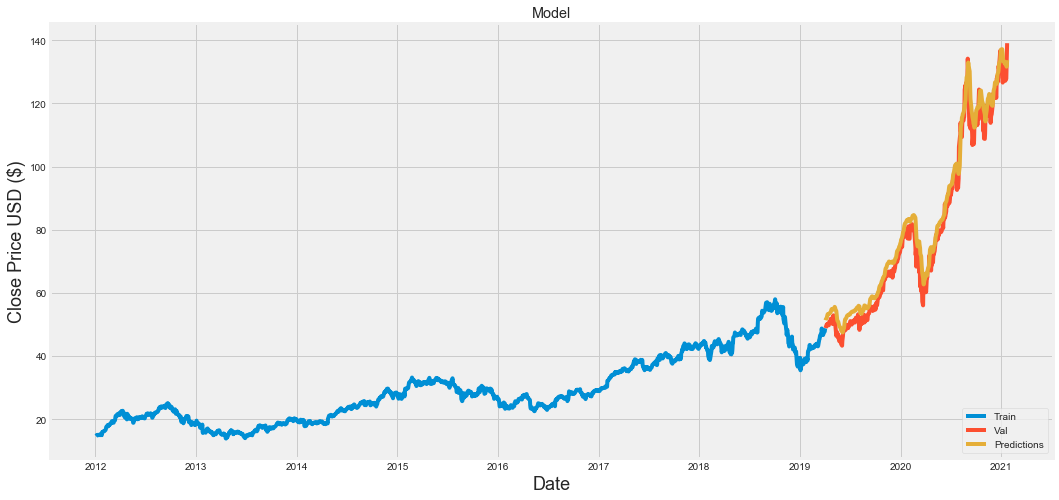

In [39]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [40]:
#Show the valid and predicted prices
valid

,Close,Predictions
Date,,
2019-04-04,48.922501,51.392582
2019-04-05,49.250000,51.719616
2019-04-08,50.025002,52.055649
2019-04-09,49.875000,52.471603
2019-04-10,50.154999,52.832584
...,...,...
2021-01-15,127.139999,132.572525
2021-01-19,127.830002,132.075333
2021-01-20,132.029999,131.635757
